In [ ]:
pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas import DataFrame as df
import fnmatch
import os
import csv
from lmfit import Model
import sympy as sym
import scipy.optimize as opt
from datetime import datetime
from IPython.display import Latex
from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel
from lmfit import Model, Parameters, minimize, fit_report
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import norm,cauchy,lognorm
import array as arr
from scipy import stats as st
from matplotlib import cm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn import preprocessing

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter

from numpy.random import seed
from numpy.random import randn

In [ ]:
#DEFINING WILLINGALE MODEL
def Willingale_if(t, F_a, alpha, T_a):
    if t<T_a:
        return F_a * np.exp(alpha - (t*alpha)/T_a)
    else:
        return F_a * np.power((t / T_a),(-alpha))

def Willingale(t, F_a, alpha, T_a):
    y = np.zeros(t.shape)
    for j in range(len(y)):
        y[j]=Willingale_if(t[j], F_a, alpha, T_a)
    return y

def log_Willingale_if(logt, logFa, alpha, logTa):
    if logt<logTa:
        return logFa + np.log10(np.e) * alpha * (1.0 - 10**logt/(10**logTa))
    else:
        return logFa - alpha * (logt - logTa)

def log_Willingale(logt, logFa, alpha, logTa):
    y = np.zeros(logt.shape)
    for j in range(len(y)):
        y[j]=log_Willingale_if(logt[j], logFa, alpha, logTa)
    return y

#DEFINING CAUCHY LORENTZIAN FUNCTION
def Cauchy_Lorentz(x, x_0, gamma):
    return ( 1 / (np.pi * gamma * (1 + ( (x-x_0) / gamma )**2 )))


GRB060719


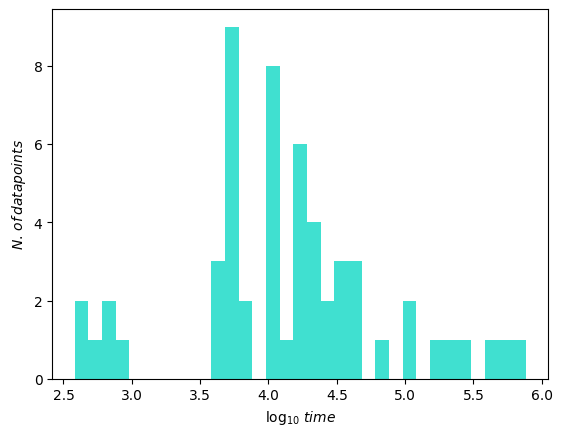

<Figure size 640x480 with 0 Axes>

In [ ]:
header_names=['t', 'pos_t_err', 'neg_t_err', 'flux', 'pos_flux_err', 'neg_flux_err']

GRB_Name="GRB060719"

GRB_parameters = pd.read_csv("545_GRBs_parameters.csv", header=0, index_col=0)

trimmed_data = pd.read_csv("/content/drive/MyDrive/GRBs_trimmed/"+GRB_Name+"_trimmed.csv", verbose=False, skiprows=1, skip_blank_lines=True, sep=',', dtype=float, header=None, names=header_names)

#GRB_new = pd.read_csv("/content/drive/MyDrive/Astro/LC Reconstruction 2/GRB_segregated_new.csv", header=0)

GRBIDs_arr = GRB_parameters.index[:] #GRB_new.iloc[:,0]

#ARRAY TO STORE GRB NAMES
Names=[]



#print(GRBIDs_arr.head())
#for i in range(528,len(GRBIDs_arr)):

    #ARRAYS TO STORE VALUES OF ORIGINAL WILLINGALE PARAMETERS FOR ALL GRBs IN THE LOOP

print(GRB_Name)
#cleaned_data = pd.read_csv("C:/Users/biagi/Desktop/GRB-SFR/LCR/All_GRBs_reconstruction/LC Reconstruction 2/GRBs_cleaned/"+GRB_Name+"_cleaned.csv", verbose=False, skiprows=2, skip_blank_lines=True, sep=',', dtype=float, header=None, names=header_names, na_filter=True)
#CLEANED DATA CONTAINS FLUX VS TIME DATA OF PROMPT AS WELL AS AFTERGLOW REGION (COMPLETE LC.). PLEASE REFER TO THE DESCRIPTION AT THE BEGINNING.
#TRIMMED DATA CONTAINS FLUX VS TIME DATA OF AFTERGLOW REGION.

#DEFINING DENSITY FACTOR
density_factor = 1

#Here we obtain the fitting parameters.

#Ta is in log scale. Fa in log scale. Alpha is linear scale.
#And tt and tfinal in log scale.
log_T_a = GRB_parameters.loc[GRB_Name, "logTa_best"]
log_T_a_min = GRB_parameters.loc[GRB_Name, "logTa_min"]
log_T_a_max = GRB_parameters.loc[GRB_Name, "logTa_max"]

log_F_a = GRB_parameters.loc[GRB_Name, "logFa"]
log_F_a_min = GRB_parameters.loc[GRB_Name, "logFa_min"]
log_F_a_max = GRB_parameters.loc[GRB_Name, "logFa_max"]

alpha = GRB_parameters.loc[GRB_Name, "alpha_best"]
alpha_min = GRB_parameters.loc[GRB_Name, "alpha_min"]
alpha_max = GRB_parameters.loc[GRB_Name, "alpha_max"]

log_Tt = GRB_parameters.loc[GRB_Name, "logTt"]
#log_Tfinal = GRB_parameters.loc[GRB_Name, "logTfinal"]


#FETCHING MAXIMUM AND MINIMUM VALUE OF FLUXES AND TIME VALUES FROM TRIMMED DATA
#THESE VALUES ARE IN LINEAR SCALE
max_fluxes = np.max(trimmed_data["flux"])
min_fluxes = np.min(trimmed_data["flux"])

max_ts = np.max(trimmed_data["t"])
min_ts = np.min(trimmed_data["t"])


#ABOVE VALUES IN LOG SCALE
log_max_fluxes = np.log10(max_fluxes)
log_min_fluxes = np.log10(min_fluxes)

log_max_ts = np.log10(max_ts)
log_min_ts = np.log10(min_ts)

#DEFINING THE ERROR VALUES FROM DATA FILE IN LINEAR SCALE

#for time
positive_ts_err = trimmed_data["pos_t_err"]
negative_ts_err = trimmed_data["neg_t_err"]

#for flux
positive_fluxes_err = trimmed_data["pos_flux_err"]
negative_fluxes_err = trimmed_data["neg_flux_err"]


#READING TIME AND FLUXES FROM THE TRIMMED DATA
#THESE VALUES ARE IN LINEAR SCALE
ts, fluxes = trimmed_data["t"].to_numpy(), trimmed_data["flux"].to_numpy()

#ABOVE VALUES IN LOG SCALE
log_ts, log_fluxes = np.log10(ts), np.log10(fluxes)


# ERROR ON THE FLUXES
pos_fluxes= fluxes + positive_fluxes_err
neg_fluxes= fluxes + negative_fluxes_err


# GENERATES TIME VALUES AT EQUAL INTERVALS IN RANGE OF TS IN LINEAR SCALE
# THIS IS TO BE USED FOR GENERATING THE TIMES AT WHICH WE RECONSTRUCT THE LC
# IT IS EQUAL TO THE NUMBER OF DATA POINTS AS THE ORIGINAL LIGHT CURVE
recon_t = np.geomspace(np.min(ts), np.max(ts), density_factor*len(ts))

#ABOVE VALUE IN LOG SCALE
log_recon_t = np.log10(recon_t)
log_recon_t = log_recon_t.reshape(-1,1)

totdensity=len(log_ts)/(max(log_ts)-min(log_ts))
    # print(totdensity)

n, bins, patches = plt.hist(log_ts, bins=np.arange(min(log_ts), max(log_ts)+0.1, step=0.1), color='turquoise')
nmean=np.mean(n)
nstd=np.std(n)

edges=np.histogram_bin_edges(log_ts, bins='auto')
#print(edges)

# seed random number generator
#print(n)
#print(np.max(n)/2)
# plt.hist(log_ts, bins=np.arange(min(log_ts), max(log_ts)+0.1, step=0.1), color='turquoise')
plt.xlabel("$\log_{10}\,time$")
plt.ylabel("$N.\,of\,datapoints$")
plt.show()
plt.clf()

gapslist=[]

for ff in range(0,len(log_ts)-1):
    lowbound=log_ts[ff]
    upbound=log_ts[ff+1]

    if np.abs(upbound-lowbound)>=0.03: #np.min(totalgaps): #0.10:

        gapslist.append([lowbound,upbound,np.abs(upbound-lowbound)])

pivotkeep=[]
for ii in range(len(log_recon_t)):
    for jj in range(len(gapslist)):
        if gapslist[jj][0]<=log_recon_t[ii]<=gapslist[jj][1]:
            pivotkeep.append(ii)

#print(pivotkeep)

logtimekeep=[[log_recon_t[f][0]] for f in pivotkeep]

logtimekeeparray=np.array(logtimekeep)

#print(type(log_recon_t))
#print(type(logtimekeeparray))

log_recon_t = logtimekeeparray

#CALCULATING ERRORBAR IN LINEAR SCALE
ts_error = (positive_ts_err - negative_ts_err )/2
fluxes_error = (positive_fluxes_err - negative_fluxes_err)/2

#CALCULATING ERRORBAR IN LOG SCALE

pos_log_fluxes = np.log10(pos_fluxes)
neg_log_fluxes = np.log10(neg_fluxes)

#ERROR PARAMETERS (LOG)
log_F_a_err = (float(log_F_a_max) - float(log_F_a_min))/2
log_T_a_err= (float(log_T_a_max) - float(log_T_a_min))/2
alpha_err = (float(alpha_max) - float(alpha_min))/2

#CALLING LOG WILLINGALE FUNCTION ON LOG PARAMETER
log_Willingale_line = log_Willingale(log_recon_t, log_F_a, alpha, log_T_a)

#RESIDUALS IN LOG SCALE
log_Willingale_line = log_Willingale(log_ts, log_F_a, alpha, log_T_a)
#log_Willingale_min = log_Willingale(log_ts, log_F_a_min, alpha_min, log_T_a_min)  #THESE COMMENTED LINES CALCULATE THE MINIMUM AND MAXIMUM WILLINGALE FIT.
#log_Willingale_max = log_Willingale(log_ts, log_F_a_max, alpha_max, log_T_a_max)

log_residuals = log_fluxes-log_Willingale_line

#FITTING THE LOG RESIDUAL HISTOGRAM WITH GAUSSIAN DISTRIBUTION

parameters = st.norm.fit(log_residuals, floc=0)
#print("The parameters of the fit are: "+ str(parameters))
fitted_dist = st.norm(scale=parameters[1])

st.kstest(log_residuals, fitted_dist.cdf)

log_Willingale_line = log_Willingale(log_recon_t, log_F_a, alpha, log_T_a)


In [ ]:
# Symmetric Log Scale Transformation
#def symmetric_log_scale(flux_values, a):
 #   return np.log(np.abs(flux_values / a)) * np.sign(flux_values)

#a = fluxes.min()  #minimum value of flux

#prepare data
#symlog_flux = symmetric_log_scale(fluxes, a)
log_fluxes = np.log10(flux)
log_ts = np.log10(ts)

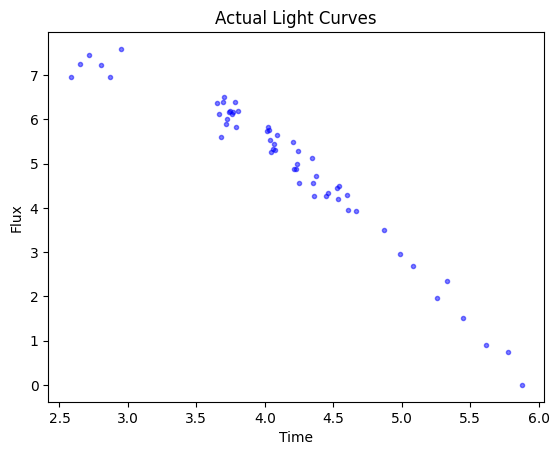

In [ ]:
plt.plot(log_ts,log_fluxes, 'b.', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title(f'Actual Light Curves')
plt.show()

In [ ]:
# upsampled_times = []
# upsampled_fluxes = []

# for i in range(len(log_ts) - 1):
#     start_time = log_ts[i]
#     end_time = log_ts[i + 1]
#     gap = end_time - start_time

#     # Check if the gap exceeds the threshold
#     if gap > 0.2:
#         # Generate new times between start and end (excluding boundaries)
#         new_times = np.linspace(start_time, end_time, num=10)[1:-1]  # Adjust `num` as needed
#         upsampled_times.extend(new_times)

# # Convert to a numpy array for further processing
# upsampled_times = np.array(upsampled_times)


In [ ]:
# from scipy.interpolate import interp1d

# interpolation_function=interp1d(log_ts, symlog_flux, kind='linear', fill_value="extrapolate")
# fluxes_imputed=interpolation_function(upsampled_times)

In [ ]:
# plt.plot(log_ts,symlog_flux, 'b.', alpha=0.5)
# plt.scatter(upsampled_times,fluxes_imputed)

# plt.xlabel('Time')
# plt.ylabel('Flux')
# plt.title(f'Actual Light Curves')
# plt.show()

In [ ]:
# # Join the arrays
# all_times = np.concatenate([log_ts, upsampled_times])
# all_fluxes = np.concatenate([symlog_flux, fluxes_imputed])

# sorted_indices = np.argsort(all_times)
# all_times = all_times[sorted_indices]
# all_fluxes = all_fluxes[sorted_indices]


In [ ]:
# plt.scatter(all_times,all_fluxes)

In [ ]:
#dividing data into training and validation

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(log_ts.reshape(-1,1), log_fluxes.reshape(-1,1), test_size=0.3, random_state=42)


print(f"Training data size: {len(X_train)}")
print(f"Validation data size: {len(X_val)}")

Training data size: 39
Validation data size: 17


In [ ]:
# #Reshaping for LSTM input (samples, time steps, features)
# #the timestep = 1

# X_train_seq = X_train.reshape(X_train.shape[0], 1, 1)
# X_val_seq = X_val.reshape(X_val.shape[0], 1, 1)

# print(f"X_train_seq shape: {X_train_seq.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_val_seq shape: {X_val_seq.shape}")
# print(f"y_val shape: {y_val.shape}")


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C, Matern
from sklearn.ensemble import RandomForestRegressor



In [ ]:
kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [ ]:
# Fit GP with best kernel
gp = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=5, random_state=42)

In [ ]:
# Get GP predictions
y_train_gp = gp.predict(X_train).reshape(-1, 1)
y_val_gp = gp.predict(X_val).reshape(-1, 1)

# Calculate residuals
residuals_train = y_train - y_train_gp
residuals_val = y_val - y_val_gp

In [ ]:
# Fine-tune Random Forest with GridSearchCV
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


# Use RandomizedSearchCV instead of GridSearchCV
rf = RandomForestRegressor( n_estimators=100)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings sampled
    cv=3,       # Reduced number of cross-validation folds
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

In [ ]:
random_search.fit(X_train, residuals_train)

# Get best RF model
best_rf = random_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


predictions = random_search.predict(X_val)

# Calculate R² score
r2 = r2_score(y_val, predictions)
print(f"R² Score: {r2}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_val, predictions)
print(f"Mean Squared Error (MSE): {mse}")

R² Score: -9.687941739444135
Mean Squared Error (MSE): 30.785006940648298


In [ ]:
print(f"y_val shape: {y_val.shape}, y_val_pred shape: {predictions.shape}")


y_val shape: (17, 1), y_val_pred shape: (17,)


In [ ]:
mse_log = mean_squared_error(np.log10(y_val), np.log10(y_val_pred))
r2_log = r2_score(np.log10(y_val), np.log10(y_val_pred))


<ipython-input-102-1ec823e29e99>:1: RuntimeWarning: invalid value encountered in log10
  mse_log = mean_squared_error(np.log10(y_val), np.log10(y_val_pred))


ValueError: Input contains NaN.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_val and y_val_pred are your original arrays

# Replace zeros and negative values with a small positive number
y_val_log = np.where(y_val <= 0, 1e-10, y_val)  # Replace with a small positive value
y_val_pred_log = np.where(y_val_pred <= 0, 1e-10, y_val_pred)  # Replace with a small positive value

# Calculate MSE and R² on the log-transformed data
mse_log = mean_squared_error(np.log10(y_val_log), np.log10(y_val_pred_log))
r2_log = r2_score(np.log10(y_val_log), np.log10(y_val_pred_log))

print(f"MSE (log-transformed): {mse_log}")
print(f"R² (log-transformed): {r2_log}")

MSE (log-transformed): 56.98306084420232
R² (log-transformed): -990.3612795423758


In [ ]:
log_recon_seq = log_recon_t.reshape(log_recon_t.shape[0], 1, 1)
log_recon_seq_reshaped = log_recon_seq.reshape(log_recon_seq.shape[0], -1)

print(f"log_recon_seq shape: {log_recon_seq_reshaped.shape}")

#Predict on new time
recon_pred = random_search.predict(log_recon_seq_reshaped)

log_recon_seq shape: (74, 1)


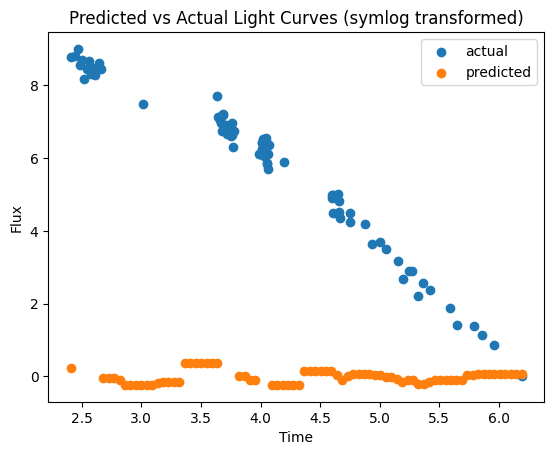

In [ ]:
plt.scatter(log_ts,symlog_flux,label='actual')
plt.scatter(log_recon_t,recon_pred,label='predicted')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title(f'Predicted vs Actual Light Curves (symlog transformed)')
plt.legend()
plt.show()

In [ ]:
# Get RF predictions for training and validation
y_train_rf = best_rf.predict(X_train).reshape(-1, 1)
y_val_rf = best_rf.predict(X_val).reshape(-1, 1)

In [ ]:

# Final predictions (GP base + RF residual correction)
y_train_final = y_train_gp + y_train_rf
y_val_final = y_val_gp + y_val_rf



In [ ]:
# Predict on reconstruction points
log_recon_seq = log_recon_t.reshape(-1, 1)
print(f"log_recon_seq shape: {log_recon_seq.shape}")
rf_pred = best_rf.predict(log_recon_seq).reshape(-1, 1)
gp_pred = gp.predict(log_recon_seq).reshape(-1, 1)
recon_pred = gp_pred + rf_pred


log_recon_seq shape: (74, 1)


In [ ]:
def inverse_symmetric_log(y, a):
    return a * (np.exp(y)) * np.sign(y)

In [ ]:
# Convert back to original scale
predicted_flux = inverse_symmetric_log(recon_pred, a)
recon_fluxes_up = np.log10(predicted_flux)

In [ ]:

#CALCULATING TIME ERROR IN LINEAR SCALE
ts_error = (positive_ts_err - negative_ts_err)/2

#CALCULATING TIME ERROR IN LOG SCALE
log_ts_error = ts_error/(ts*np.log(10))

errparameters = st.norm.fit(log_ts_error) #GAUSSIAN FITTING ON TIME ERROR DISTRIBUTION
err_dist_time = st.norm(loc=errparameters[0], scale=errparameters[1])

recon_logtimeerr=err_dist_time.rvs(size=len(log_recon_t)) # len(log_ts_error)


In [ ]:
#adding noise
fluxes_error = (positive_fluxes_err - negative_fluxes_err)/2
logfluxerrs = fluxes_error/(fluxes*np.log(10))

errparameters = st.norm.fit(logfluxerrs) #GAUSSIAN FITTING ON ERROR-BAR DISTRIBUTION
err_dist = st.norm(loc=errparameters[0], scale=errparameters[1])

recon_errorbar=err_dist.rvs(size=len(log_recon_t))

#Point specific noise
point_specific_noise = []
for j in range(len(recon_fluxes_up)):
    fitted_dist = st.norm(loc=recon_fluxes_up[j], scale=recon_errorbar[j])
    point_noise = fitted_dist.rvs() - recon_fluxes_up[j]
    point_specific_noise.append(point_noise)
point_specific_noise = np.array(point_specific_noise)

#Jiggle reconstructed points
jiggled_points = recon_fluxes_up + point_specific_noise

In [ ]:
# Generate multiple realizations with noise
num_samples = 1000
jiggled_realizations = []

for _ in range(num_samples):
    point_specific_noise = []
    for j in range(len(recon_fluxes_up)):
        fitted_dist = norm(loc=recon_fluxes_up[j], scale=recon_errorbar[j])
        point_noise = fitted_dist.rvs() - recon_fluxes_up[j]
        point_specific_noise.append(point_noise)
    jiggled_realizations.append(recon_fluxes_up + np.array(point_specific_noise))

jiggled_realizations = np.array(jiggled_realizations)

# Calculate statistics
mean_jiggled = np.mean(jiggled_realizations, axis=0)
ci_95_lower = np.percentile(jiggled_realizations, 2.5, axis=0)
ci_95_upper = np.percentile(jiggled_realizations, 97.5, axis=0)

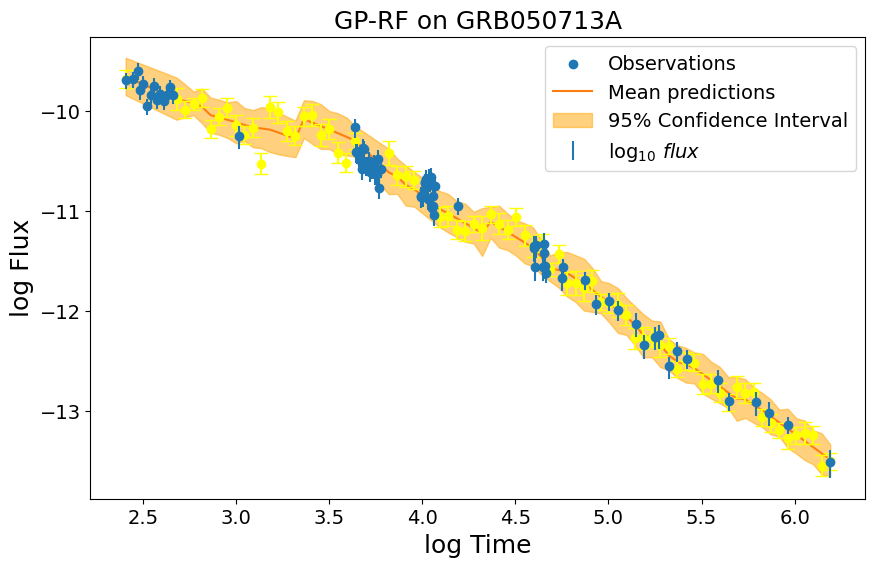

In [ ]:
# Flatten arrays for plotting
ci_95_lower = ci_95_lower.flatten()
ci_95_upper = ci_95_upper.flatten()
log_recon_t = log_recon_t.flatten()
jiggled_points = (recon_fluxes_up + point_specific_noise).flatten()

# Create final plot
plt.figure(figsize=(10, 6))
plt.errorbar(log_ts, log_fluxes, yerr=[log_fluxes-neg_log_fluxes,pos_log_fluxes-log_fluxes], label=r"$\log_{10}\,flux$", linestyle="", zorder=4)
plt.errorbar(log_recon_t, jiggled_points, linestyle='none', yerr=np.abs(recon_errorbar), marker='o', capsize=5, color='yellow', zorder=3)

plt.scatter(log_ts, log_fluxes, label='Observations', zorder=5)
plt.plot(log_recon_t, recon_fluxes_up, label='Mean predictions', zorder=2)
plt.fill_between(log_recon_t, np.squeeze(ci_95_lower), np.squeeze(ci_95_upper), color='orange', alpha=0.5, label='95% Confidence Interval', zorder=1)

plt.xlabel('log Time', fontsize=18)
plt.ylabel('log Flux', fontsize=18)
plt.title(f'GP-RF on {GRB_Name}', fontsize=18)

plt.tick_params(axis='both', labelsize=14)

plt.legend(fontsize=14)
#plt.savefig(f"Saved_Outputs/{GRB_Name}/{GRB_Name}.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save results to CSV
df = trimmed_data.copy(deep=True)
for k in range(0, len(log_recon_t)):
    new_row = {
        "t": 10**log_recon_t[k],
        "pos_t_err": 10**recon_logtimeerr[k],
        "neg_t_err": 10**recon_logtimeerr[k],
        "flux": 10**jiggled_points[k],
        "pos_flux_err": 10**jiggled_points[k] * np.log(10) * recon_errorbar[k],
        "neg_flux_err": 10**jiggled_points[k] * np.log(10) * recon_errorbar[k]
    }

    new_row_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_row_df], ignore_index=True)
#df.to_csv(f'/content/drive/MyDrive/GP+Rf training GRBs/csv files/{GRB_Name}_tuned.csv')